# Description

Sees how well CNN_7_0 can predict if promoters from Urtecho 2023's data expression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns

In [2]:
# Helper functions for data preprocessing
def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

def padded_one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], '0': [0, 0, 0, 0]}
    return np.array([mapping[nucleotide.upper()] for nucleotide in sequence])

In [3]:
model = keras.saving.load_model('../../Models/CNN_7_0.keras')

c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
df = pd.read_csv('../../Data/Urtecho_2023/Urtecho_2023.csv')
df.head()

,promoter_sequence,expn_med_fitted,active,expn_med_fitted_boxcox,expn_med_fitted_minmax_boxcox
0,TCCCGTGCTATGTTATTGACACACAAAAGCGTTGAGGAACAGTGAG...,1.860559,0,0.374737,0.722556
1,TATGTAATCTATCGTAATACTTCGATTGGTAAAATTCATCGATCGA...,1.611377,0,0.320787,0.641067
2,GTCGTAAACACCCGGTATAGCGGGGTTACCTTCACTGTACCGGCTG...,1.350123,0,0.232217,0.507286
3,GTTGTTACCAGTGAAAATTTAAGGTCGGTGCTCATCAAGTTTTCTC...,1.385900,0,0.247143,0.529831
4,CAATCTCCATTCTCACAGTGAAACGTAACGTACTGAAAACGGGTGA...,1.974071,0,0.393221,0.750477


In [5]:
# Group the data by condition
X_test = df['promoter_sequence']
y_test = df['expn_med_fitted_minmax_boxcox']

y_pred = model.predict(preprocess_sequences(X_test)).flatten()

1413/1413 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [6]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='uniform')
y_test_q = qt.fit_transform(np.array(y_test).reshape(-1, 1)).flatten()
y_pred_q = qt.fit_transform(np.array(y_pred).reshape(-1, 1)).flatten()

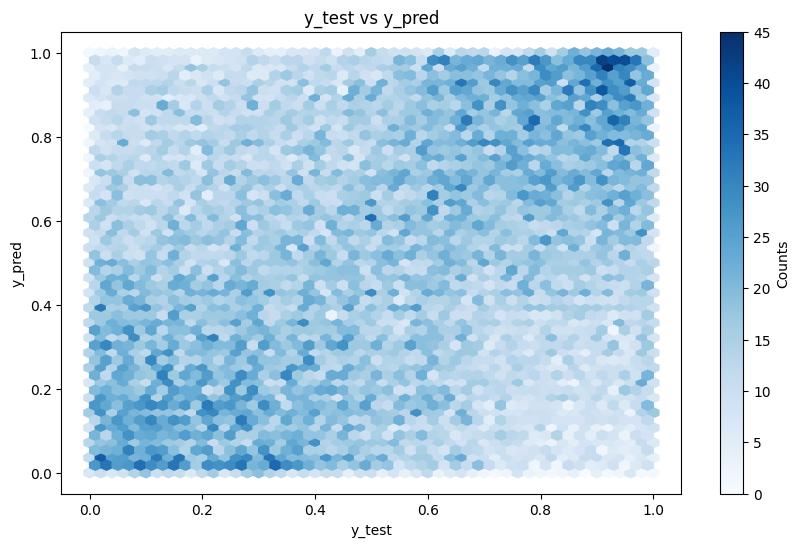

In [8]:
# graph y_test vs y_pred
plt.figure(figsize=(10, 6))
plt.hexbin(y_test_q, y_pred_q, gridsize=50, cmap='Blues')
plt.colorbar(label='Counts')
plt.title('y_test vs y_pred')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

In [9]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance

# Calculate Pearson correlation coefficient
corr, p_value = pearsonr(y_test_q, y_pred_q)
print(f"Pearson correlation coefficient: {corr:.4f}, p-value: {p_value:.4e}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_q, y_pred_q)
print(f"Quantile MAE: {mae:.3f}")

# Calculate R2 score
r2 = r2_score(y_test_q, y_pred_q)
print(f"R² score (on quantiles): {r2:.3f}")

# Calculate Wasserstein distance
w_dist = wasserstein_distance(y_test_q, y_pred_q)
print(f"Wasserstein distance: {w_dist:.3f}")

Pearson correlation coefficient: 0.2510, p-value: 0.0000e+00
Quantile MAE: 0.282
R² score (on quantiles): -0.505
Wasserstein distance: 0.007


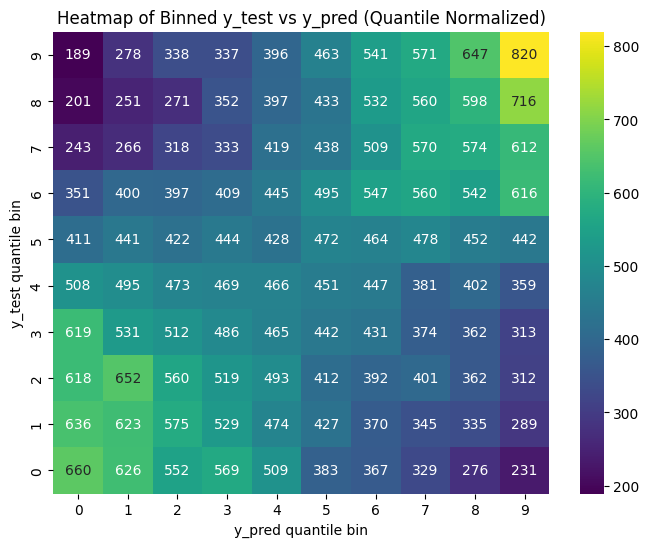

In [10]:
# Create a 2D histogram / contingency table for binned data

bins = np.linspace(0, 1, 11)
y_test_bins = np.digitize(y_test_q, bins) - 1
y_pred_bins = np.digitize(y_pred_q, bins) - 1

y_test_bins = np.clip(y_test_bins, 0, 9)
y_pred_bins = np.clip(y_pred_bins, 0, 9)

bin_counts = pd.crosstab(y_test_bins, y_pred_bins)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(bin_counts, annot=True, fmt="d", cmap="viridis")
plt.title("Heatmap of Binned y_test vs y_pred (Quantile Normalized)")
plt.xlabel("y_pred quantile bin")
plt.ylabel("y_test quantile bin")
plt.gca().invert_yaxis()
plt.show()

In [15]:
for i in range(len(bins) - 1):
    print(bin_counts[i].sum(), end=", ")

4436, 4563, 4418, 4447, 4492, 4416, 4600, 4569, 4550, 4710, 

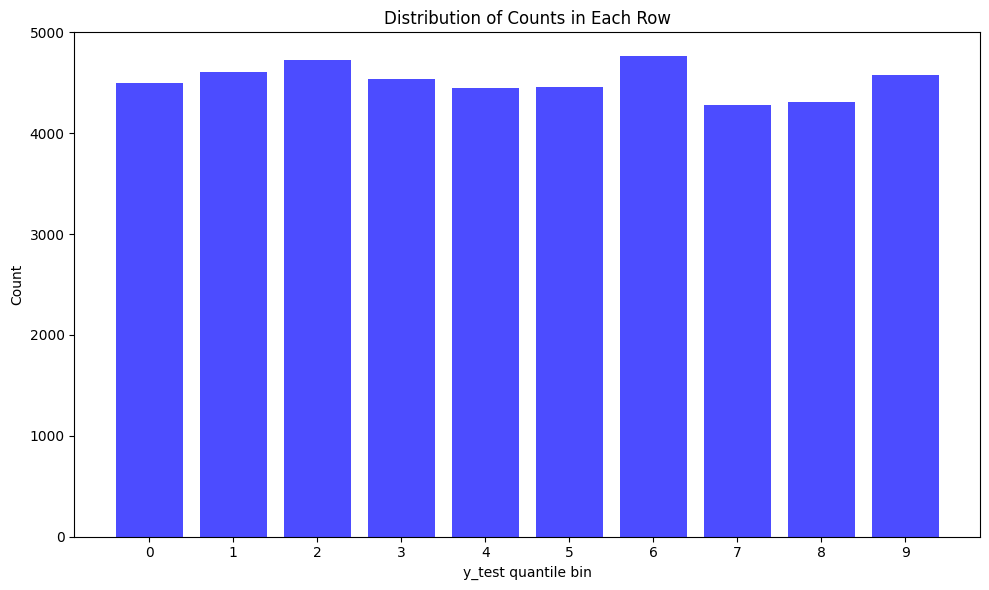

In [24]:
# graph the distribution of counts in each row

plt.figure(figsize=(10, 6))
plt.bar(range(len(bin_counts)), bin_counts.sum(axis=1), color='blue', alpha=0.7)
plt.xlabel('y_test quantile bin')
plt.ylabel('Count')
plt.title('Distribution of Counts in Each Row')
plt.xticks(range(len(bin_counts.columns)))
plt.tight_layout()
plt.show()


In [30]:
# graph the distribution of counts in each row
print("Counts in each row:")
for each in bin_counts.sum(axis=1):
    print(each, end=", ")

print("\n\nCounts in each column:")
# graph the distribution of counts in each column
for each in bin_counts.sum(axis=0):
    print(each, end=", ")

Counts in each row:
4502, 4603, 4721, 4535, 4451, 4454, 4762, 4282, 4311, 4580, 

Counts in each column:
4436, 4563, 4418, 4447, 4492, 4416, 4600, 4569, 4550, 4710, 

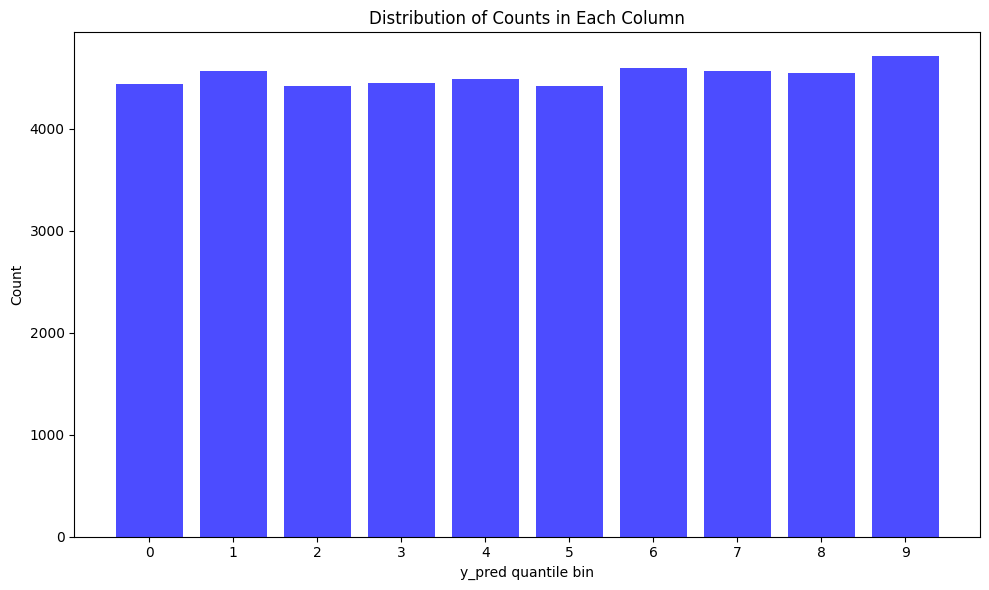

In [23]:
# graph the distribution of counts in each column

plt.figure(figsize=(10, 6))
plt.bar(range(len(bin_counts.columns)), bin_counts.sum(axis=0), color='blue', alpha=0.7)
plt.xlabel('y_pred quantile bin')
plt.ylabel('Count')
plt.title('Distribution of Counts in Each Column')
plt.xticks(range(len(bin_counts.columns)))
plt.tight_layout()
plt.show()



In [18]:
bin_counts[0]

row_0
0    660
1    636
2    618
3    619
4    508
5    411
6    351
7    243
8    201
9    189
Name: 0, dtype: int64

In [11]:
from sklearn.metrics import mutual_info_score
from scipy.special import rel_entr
from sklearn.metrics import accuracy_score, f1_score

# Calculate the diagonal dominance score
total = bin_counts.values.sum()
diagonal = np.trace(bin_counts.values)
diagonal_accuracy = diagonal / total
print(f"Diagonal Dominance Score: {diagonal_accuracy:.3f}")

# Calculate Pearson correlation coefficient
corr, p_value = pearsonr(y_test_q, y_pred_q)
print(f"Pearson correlation coefficient: {corr:.4f}, p-value: {p_value:.4e}")

# Calculate Mutual Information
mi = mutual_info_score(y_test_bins, y_pred_bins)
print(f"Mutual Information (bins): {mi:.3f}")

# Calculate KL Divergence
joint_pred = bin_counts.values / bin_counts.values.sum()
ideal = np.zeros_like(joint_pred)
np.fill_diagonal(ideal, 1 / 10)
kl_div = np.sum(rel_entr(joint_pred + 1e-10, ideal + 1e-10))
print(f"KL Divergence from ideal: {kl_div:.3f}")

# Calculate accuracy and F1 score for binned predictions
acc = accuracy_score(y_test_bins, y_pred_bins)
f1 = f1_score(y_test_bins, y_pred_bins, average='macro')
print(f"Bin Accuracy: {acc:.3f}")
print(f"Macro F1 Score: {f1:.3f}")

Diagonal Dominance Score: 0.128
Pearson correlation coefficient: 0.2510, p-value: 0.0000e+00
Mutual Information (bins): 0.034
KL Divergence from ideal: 15.795
Bin Accuracy: 0.128
Macro F1 Score: 0.128
